# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import os

# **Check and display dataset files**

**Four Total Classes**

1. move backward
2. move forward
3. rotate left
4. rotate right

**1.5 seconds per sample, 400 samples per class**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/robot-operation-dataset/metadata.csv
/kaggle/input/robot-operation-dataset/backward/backward_270.wav
/kaggle/input/robot-operation-dataset/backward/backward_56.wav
/kaggle/input/robot-operation-dataset/backward/backward_147.wav
/kaggle/input/robot-operation-dataset/backward/backward_38.wav
/kaggle/input/robot-operation-dataset/backward/backward_49.wav
/kaggle/input/robot-operation-dataset/backward/backward_132.wav
/kaggle/input/robot-operation-dataset/backward/backward_160.wav
/kaggle/input/robot-operation-dataset/backward/backward_18.wav
/kaggle/input/robot-operation-dataset/backward/backward_17.wav
/kaggle/input/robot-operation-dataset/backward/backward_67.wav
/kaggle/input/robot-operation-dataset/backward/backward_210.wav
/kaggle/input/robot-operation-dataset/backward/backward_63.wav
/kaggle/input/robot-operation-dataset/backward/backward_278.wav
/kaggle/input/robot-operation-dataset/backward/backward_372.wav
/kaggle/input/robot-operation-dataset/backward/backward_99.w

# **Play an audio sample to ensure proper loading**

In [3]:
import IPython.display as ipd
filepath = "/kaggle/input/robot-operation-dataset/backward/backward_0.wav"
filepath2 = "/kaggle/input/robot-operation-dataset/forward/forward_0.wav"
filepath3 = "/kaggle/input/robot-operation-dataset/left/left_0.wav"
filepath4 = "/kaggle/input/robot-operation-dataset/right/right_0.wav"

ipd.Audio(filepath)

# **Plot to visualize audio samples of different operation**

Text(0.5, 1.0, 'right_1')

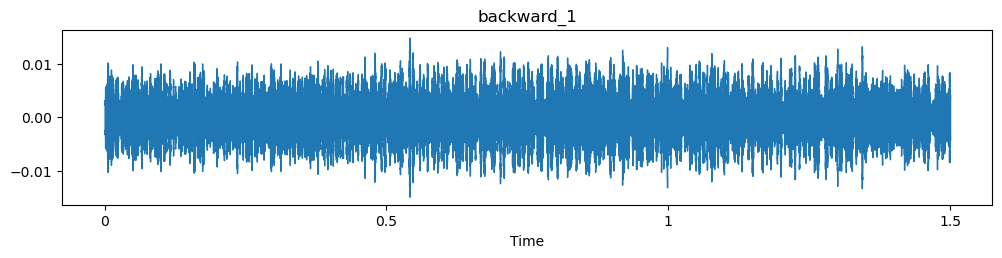

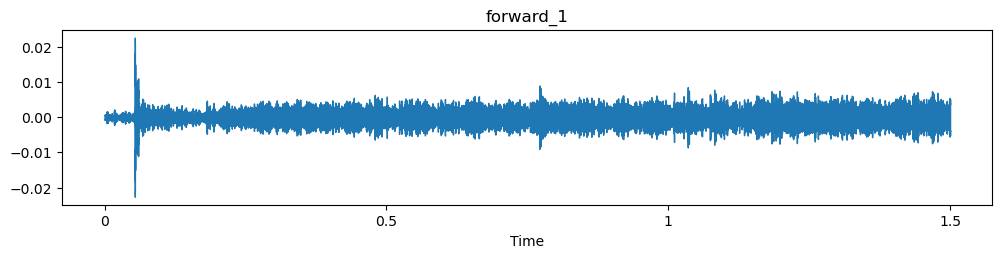

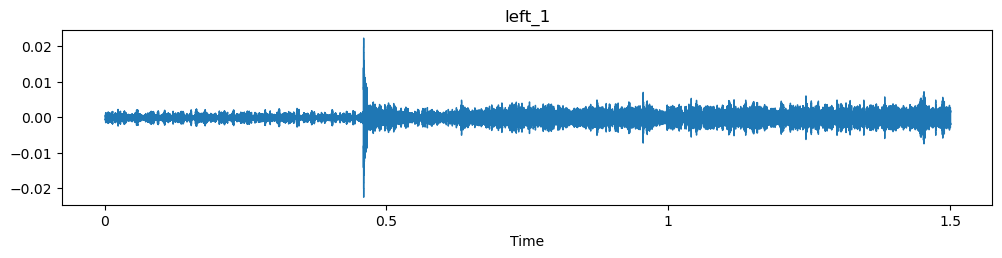

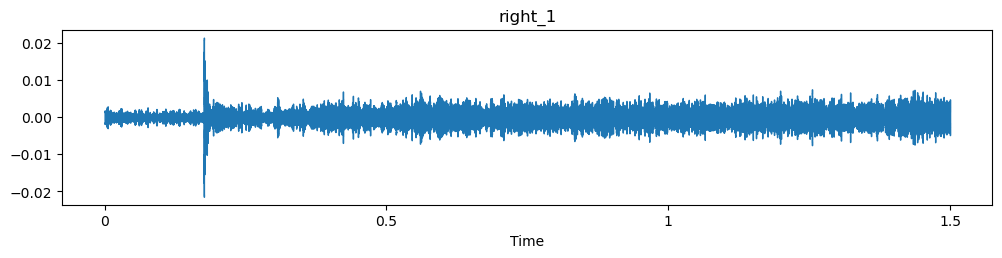

In [4]:
import librosa
import librosa.display
data, sample_rate = librosa.load(filepath)
plt.figure(figsize=(12, 5))
plot_a = plt.subplot(211)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('backward_1')

data, sample_rate = librosa.load(filepath2)
plt.figure(figsize=(12, 5))
plot_a = plt.subplot(211)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('forward_1')

data, sample_rate = librosa.load(filepath3)
plt.figure(figsize=(12, 5))
plot_a = plt.subplot(211)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('left_1')

data, sample_rate = librosa.load(filepath4)
plt.figure(figsize=(12, 5))
plot_a = plt.subplot(211)
librosa.display.waveshow(data, sr=sample_rate)
plt.title('right_1')

In [5]:
# 88200 data points, 22050 sample rate, 88200/22050=4, thus 4 seconds audio clip
print("Data:", data, '\n')
print("Sample Rate:", sample_rate, '\n')
print("Data Shape:", data.shape, '\n')

# Find max value
print("Max Amplitude:", max(data), '\n')

# Find index of max value
print("Index of Max Amplitude:", np.argmax(data))

Data: [ 1.0898750e-03  1.6629662e-03  1.3425285e-03 ...  1.9225016e-03
 -3.0874854e-04 -6.4965861e-06] 

Sample Rate: 22050 

Data Shape: (33075,) 

Max Amplitude: 0.017603088 

Index of Max Amplitude: 3873


# **Load and check metadata**

In [6]:
metadata = pd.read_csv('/kaggle/input/robot-operation-dataset/metadata.csv')
print(metadata['Class'].value_counts())
metadata.head(10)

backward    400
forward     400
left        400
right       400
Name: Class, dtype: int64


,Chunk,Chunk Path,Class
0,backward_0.wav,backward\backward_0.wav,backward
1,backward_1.wav,backward\backward_1.wav,backward
2,backward_2.wav,backward\backward_2.wav,backward
3,backward_3.wav,backward\backward_3.wav,backward
4,backward_4.wav,backward\backward_4.wav,backward
5,backward_5.wav,backward\backward_5.wav,backward
6,backward_6.wav,backward\backward_6.wav,backward
7,backward_7.wav,backward\backward_7.wav,backward
8,backward_8.wav,backward\backward_8.wav,backward
9,backward_9.wav,backward\backward_9.wav,backward


# **Data Preprocessing**

In [7]:
audio_dataset_path="/kaggle/input/robot-operation-dataset"

In [8]:
# Function to extract features
def features_extractor(file):
    audio, sample_rate = librosa.load(file) 
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=15)
    mfccs_avg = np.mean(mfccs, axis=1)
    
    # Extract Root Mean Square
    rms = librosa.feature.rms(y=audio)
    rms_avg = np.mean(rms, axis=1)
    
    # Extract Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    zcr_avg = np.mean(zcr, axis=1)
    
    # Extract Spectral Centroid
    spc = librosa.feature.spectral_centroid(y=audio)
    spc_avg = np.mean(spc, axis=1)
    
    # Extract Spectral Bandwidth
    spb = librosa.feature.spectral_bandwidth(y=audio)
    spb_avg = np.mean(spb, axis=1)
    
    # Extract Spectral Rolloff
    spr = librosa.feature.spectral_rolloff(y=audio)
    spr_avg = np.mean(spr, axis=1)
    
    
    return mfccs_avg, rms_avg, zcr_avg, spc_avg, spb_avg, spr_avg

In [9]:
# Test feature extractor function
test = features_extractor(filepath)
test

(array([-4.1473364e+02,  6.7971382e+01,  8.0360184e+00,  4.3910522e+01,
         1.5505186e+00,  3.2242771e+01,  2.6301165e+00, -3.2050261e-01,
         1.9111662e+00,  1.5310724e+01, -2.3729753e-01, -2.7031205e+00,
         5.0171976e+00,  1.3669151e+00, -5.8151956e+00], dtype=float32),
 array([0.00397665], dtype=float32),
 array([0.09342698]),
 array([2785.53993886]),
 array([2710.44795089]),
 array([5804.52336238]))

In [10]:
# Create an empty DataFrame
df_features = pd.DataFrame()

# Iterate through every audio file and extract features
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), str(row["Class"]), str(row["Chunk"]))
    final_class_labels = row["Class"]
    mfccs_avg, rms_avg, zcr_avg, spc_avg, spb_avg, spr_avg = features_extractor(file_name)
    
    # Create a dictionary of feature values
    feature_dict = {
        **{f'MFCC_{i+1}': mfccs_avg[i] for i in range(len(mfccs_avg))},
        'RMS_avg': rms_avg[0],
        'ZCR_avg': zcr_avg[0],
        'Spectral_Centroid_avg': spc_avg[0],
        'Spectral_Bandwidth_avg': spb_avg[0],
        'Spectral_Rolloff_avg': spr_avg[0],
        'Class': final_class_labels
    }
    
    # Append the feature values to the DataFrame
    df_features = df_features.append(feature_dict, ignore_index=True)

1600it [02:22, 11.23it/s]


In [11]:
print(df_features.shape)
df_features.head()

(1600, 21)


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCC_12,MFCC_13,MFCC_14,MFCC_15,RMS_avg,ZCR_avg,Spectral_Centroid_avg,Spectral_Bandwidth_avg,Spectral_Rolloff_avg,Class
0,-414.733643,67.971382,8.036018,43.910522,1.550519,32.242771,2.630116,-0.320503,1.911166,15.310724,...,-2.703120,5.017198,1.366915,-5.815196,0.003977,0.093427,2785.539939,2710.447951,5804.523362,backward
1,-413.948151,68.390739,5.026476,42.217754,-0.277212,30.748562,3.918812,0.484412,1.441668,12.807572,...,-2.517540,5.533735,1.963421,-6.670405,0.003330,0.120252,2844.628297,2687.007980,5799.719802,backward
2,-411.889984,70.105675,5.553467,42.853565,0.886124,31.684090,5.412685,2.657615,3.831141,14.399577,...,-1.590047,6.627328,2.735632,-6.376879,0.005045,0.065002,2657.190995,2680.744867,5686.587665,backward
3,-414.677124,69.240967,5.001983,40.921749,-1.607408,30.247055,3.736283,0.333294,0.744817,12.751386,...,-3.542459,5.099046,0.695701,-8.053843,0.003386,0.120928,2845.404990,2681.376240,5797.235201,backward
4,-412.412048,69.463982,4.248728,42.407425,-0.216935,31.655203,4.966152,3.587127,2.673823,12.434652,...,-1.115399,7.113293,3.041947,-5.662322,0.004343,0.078441,2735.580396,2674.966754,5723.028471,backward


In [12]:
# Separate features (X) and labels (y)
X = df_features.drop('Class', axis=1).values
y = df_features['Class'].values
print('Original class variables: ', y, '\n')

# Normalize the features between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Encode class variables to numerical values classification 
# 0=backward, 1=forward, 2=left, 3=right
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(y)
print('Numerically encoded class variables: ', labels)
print('0=backward, 1=forward, 2=left, 3=right \n')

# One-Hot encode class variables
y = to_categorical(labels)
print('One-Hot encoded class variables: \n', y)

Original class variables:  ['backward' 'backward' 'backward' ... 'right' 'right' 'right'] 

Numerically encoded class variables:  [0 0 0 ... 3 3 3]
0=backward, 1=forward, 2=left, 3=right 

One-Hot encoded class variables: 
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [13]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Print the shapes of the arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print('\n', X_train)

X_train shape: (1280, 20)
y_train shape: (1280, 4)
X_test shape: (320, 20)
y_test shape: (320, 4)

 [[-0.05689572 -0.68970455 -0.67043412 ...  0.81893279 -0.67648532
   0.43768417]
 [-0.10270545 -0.49579218 -0.61909215 ...  0.64946184 -0.68785956
   0.1575663 ]
 [ 0.91082431  0.75545334  0.29816598 ... -0.49464792 -0.50165254
  -0.61206448]
 ...
 [ 0.60468708  0.02992493 -0.42790918 ...  0.23499227 -0.19878214
  -0.0240943 ]
 [ 0.58342436  0.04364989 -0.28031844 ...  0.25872699  0.02563679
   0.15132605]
 [ 0.52943324  0.08692968 -0.4914791  ...  0.20160675 -0.27828544
  -0.05841567]]


# **Audio Classification Model Creation**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

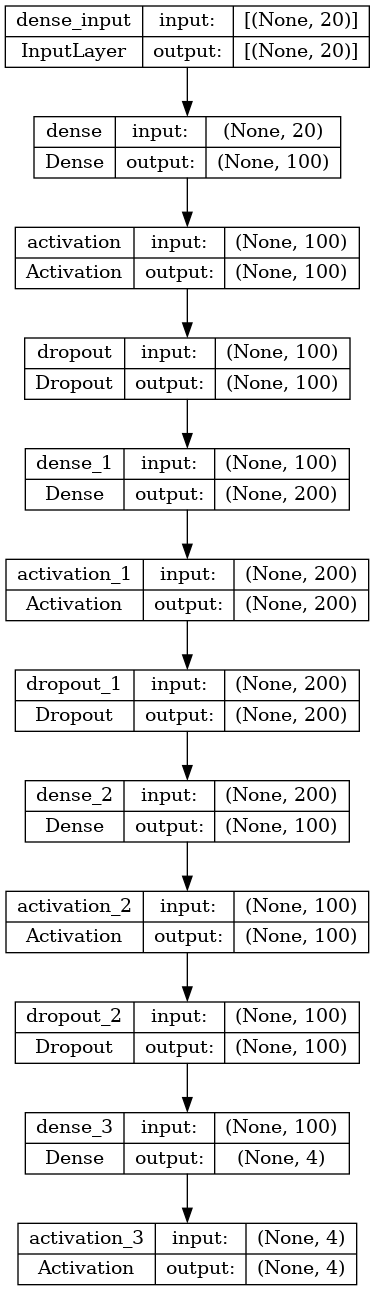

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
# No of classes
num_labels=y.shape[1]
model=Sequential()

# First layer
model.add(Dense(100,input_shape=(X.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

# View model summary
model.summary()

# Plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Compile the model**

In [15]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# **Train the model**

In [16]:
# Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 30
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
39/40 [============================>.] - ETA: 0s - loss: 0.4875 - accuracy: 0.9231
Epoch 1: val_loss improved from inf to 0.00649, saving model to ./audio_classification.hdf5
40/40 [==============================] - 2s 11ms/step - loss: 0.4758 - accuracy: 0.9250 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 2/30
20/40 [==============>...............] - ETA: 0s - loss: 0.0155 - accuracy: 0.9969
Epoch 2: val_loss improved from 0.00649 to 0.00077, saving model to ./audio_classification.hdf5
40/40 [==============================] - 0s 4ms/step - loss: 0.0127 - accuracy: 0.9969 - val_loss: 7.6554e-04 - val_accuracy: 1.0000
Epoch 3/30
22/40 [===============>..............] - ETA: 0s - loss: 0.0057 - accuracy: 0.9986
Epoch 3: val_loss improved from 0.00077 to 0.00024, saving model to ./audio_classification.hdf5
40/40 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 2.3796e-04 - val_accuracy: 1.0000
Epoch 4/30
39/40 [====================

# **Check test accuracy**

In [17]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

1.0


In [18]:
#model.predict_classes(X_test)
predict=model.predict(X_test) 
classes_x=np.argmax(predict,axis=1)
print(classes_x)

10/10 [==============================] - 0s 2ms/step
[2 1 2 2 0 2 2 3 0 1 0 0 0 1 1 1 0 3 2 0 2 0 2 3 3 3 2 2 1 0 2 2 1 3 2 1 2
 2 2 1 1 3 2 1 3 1 3 0 2 1 0 2 3 2 0 2 0 2 2 3 1 1 0 2 2 3 1 3 0 0 2 3 3 1
 1 2 0 0 2 3 0 0 2 0 2 3 2 0 0 0 3 3 1 2 2 3 2 2 2 3 2 1 0 2 0 2 3 0 3 2 1
 3 3 2 2 0 0 0 3 0 2 1 0 0 3 1 3 3 3 3 0 3 3 1 1 1 2 2 1 1 0 2 2 3 3 1 2 2
 0 2 0 3 1 2 2 2 2 3 0 2 3 0 0 1 3 0 0 0 1 0 3 1 0 1 3 0 3 1 3 1 3 1 1 3 1
 1 2 3 1 0 1 2 2 0 1 2 3 2 3 3 0 3 2 2 3 1 3 0 0 3 2 1 0 3 1 1 2 3 0 0 3 0
 3 3 2 2 1 1 1 3 1 0 2 0 0 1 3 3 1 3 0 0 1 3 2 3 0 2 0 2 0 2 0 1 1 3 1 3 2
 0 0 0 1 3 1 1 2 3 1 0 1 2 3 2 3 1 1 3 1 3 1 2 0 1 1 0 1 2 2 3 2 2 3 2 1 1
 1 1 3 2 1 1 2 1 1 1 0 2 1 1 2 3 3 2 0 1 3 3 2 3]


In [19]:
predict.shape

(320, 4)

In [20]:
y_test.shape

(320, 4)

In [21]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
# accuracy: (tp + tn) / (p + n)

y_predict=np.argmax(predict, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_predict)
print(cm)
print('\n\nClassification Report : \n\n',classification_report(y_test,y_predict))
accuracy = accuracy_score(y_test,y_predict)
print('Accuracy: %f' % accuracy)

[[72  0  0  0]
 [ 0 81  0  0]
 [ 0  0 87  0]
 [ 0  0  0 80]]


Classification Report : 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        87
           3       1.00      1.00      1.00        80

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy: 1.000000


# **Test audio sample**

In [22]:
testfilename="/kaggle/input/robot-operation-dataset/right/right_123.wav"

testdf_features = pd.DataFrame()

mfccs_avg, rms_avg, zcr_avg, spc_avg, spb_avg, spr_avg = features_extractor(testfilename)
    
# Create a dictionary of feature values
testfeature_dict = {
    **{f'MFCC_{i+1}': mfccs_avg[i] for i in range(len(mfccs_avg))},
    'RMS_avg': rms_avg[0],
    'ZCR_avg': zcr_avg[0],
    'Spectral_Centroid_avg': spc_avg[0],
    'Spectral_Bandwidth_avg': spb_avg[0],
    'Spectral_Rolloff_avg': spr_avg[0],
}



# Append the feature values to the DataFrame
testdf_features = testdf_features.append(testfeature_dict, ignore_index=True)
Xtest = testdf_features.values

#print(Xtest, '\n')

# Apply same normalization from training set to test data
Xtest = scaler.transform(Xtest)

#print(Xtest)

x_predict=model.predict(Xtest)
predicted_label=np.argmax(x_predict, axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)

1/1 [==============================] - 0s 77ms/step
[3]
['right']
